In [1]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score)
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap
from scipy.interpolate import interp1d

# 固定随机种子
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# --------------------------
# 时间序列增强模块（SimCLR增强）
# --------------------------
class TemporalTransform:
    """SimCLR风格的时间序列增强"""
    
    def __init__(self, sigma_range=(0.05, 0.1), warp_ratio=0.2):
        self.sigma_range = sigma_range
        self.warp_ratio = warp_ratio
        
    def __call__(self, x):
        # 返回形状为(batch_size, 2, seq_len, features)
        augmented = torch.stack([self._augment(x) for _ in range(2)], dim=1)
        return augmented
    
    def _augment(self, x):
        # 随机加噪
        sigma = np.random.uniform(*self.sigma_range)
        x = x + torch.randn_like(x) * sigma
        
        # 时间扭曲
        if np.random.rand() < self.warp_ratio:
            x = self.time_warp(x)
            
        return x
    
    def time_warp(self, x):
        orig_steps = np.arange(x.shape[-1])
        new_steps = orig_steps * np.random.uniform(0.9, 1.1)
        interp = interp1d(orig_steps, x.cpu().numpy(), axis=-1, kind='linear')
        return torch.tensor(interp(new_steps), dtype=torch.float32, device=x.device)

In [2]:
# --------------------------
# 位置编码模块
# --------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x形状: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x


In [3]:
class TimeSeriesTransformer(nn.Module):
    """仅包含特征提取部分"""
    def __init__(self, input_dim, d_model=64, nhead=4, 
                num_layers=3, dim_feedforward=256):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # 计算特征维度
        with torch.no_grad():
            dummy = torch.randn(2, 1, input_dim)
            dummy = self.embedding(dummy)
            dummy = self.pos_encoder(dummy)
            dummy = self.transformer(dummy)
            self.feature_dim = dummy.view(dummy.size(0), -1).shape[1]

    def forward(self, x):
        # 输入形状: (batch, 1, input_dim)
        x = self.embedding(x)
        x = self.pos_encoder(x)
        features = self.transformer(x)
        return features.view(features.size(0), -1)  # (batch, feature_dim)

class TimeSeriesClassifier(nn.Module):
    """分类头"""
    def __init__(self, feature_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x).squeeze(-1)


In [4]:
# --------------------------
# SimCLR预训练模块
# --------------------------
class SimCLR(nn.Module):
    def __init__(self, encoder, projection_dim=128):
        super().__init__()
        self.encoder = encoder
        self.projector = nn.Sequential(
            nn.Linear(128, 256),  # 匹配encoder的输出维度
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )
        
    def forward(self, x):
        features = self.encoder(x)
        return self.projector(features)


def simclr_loss(features, temperature=0.1):
    batch_size = features.shape[0] // 2
    
    # 归一化特征
    features = nn.functional.normalize(features, dim=1)
    
    # 计算相似度矩阵
    similarity_matrix = torch.mm(features, features.T)
    
    # 创建正样本对掩码
    mask = torch.eye(2*batch_size, dtype=torch.bool, device=device)
    mask = mask ^ torch.eye(2*batch_size, dtype=torch.bool, device=device)  # 移除自对角线
    pos_mask = mask[torch.arange(2*batch_size), 
                    (torch.arange(2*batch_size) + batch_size) % (2*batch_size)]
    
    # 计算对比损失
    positives = similarity_matrix[pos_mask].reshape(2*batch_size, 1)
    negatives = similarity_matrix[~pos_mask].reshape(2*batch_size, -1)
    
    logits = torch.cat([positives, negatives], dim=1) / temperature
    labels = torch.zeros(2*batch_size, dtype=torch.long, device=device)
    
    return nn.CrossEntropyLoss()(logits, labels)

# --------------------------
# 注意力融合模块
# --------------------------
class AttentionFusion(nn.Module):
    def __init__(self, modelA, modelB, hidden_dim=64):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.attention = nn.Sequential(
            nn.Linear(256, hidden_dim),  # 假设每个模型输出128维特征
            nn.Tanh(),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Linear(256, 1)
        
    def forward(self, x1, x2):
        with torch.no_grad():
            featA = self.modelA(x1)
            featB = self.modelB(x2)
        combined = torch.cat([featA, featB], dim=1)
        weights = self.attention(combined)
        fused = weights[:, 0:1] * featA + weights[:, 1:2] * featB
        return self.fc(fused).squeeze()

# --------------------------
# 训练流程函数
# --------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X, y in tqdm(loader, desc="Training"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_model(model, loader, device):
    model.eval()
    y_true, y_probs = [], []
    with torch.no_grad():
        for X, y in tqdm(loader, desc="Evaluating"):
            X = X.to(device)
            outputs = model(X)
            y_true.extend(y.cpu().numpy())
            y_probs.extend(torch.sigmoid(outputs).cpu().numpy())
    return y_true, y_probs

def compute_metrics(y_true, y_probs):
    auc = roc_auc_score(y_true, y_probs)
    preds = np.round(y_probs)
    return {
        'auc': auc,
        'accuracy': accuracy_score(y_true, preds),
        'precision': precision_score(y_true, preds),
        'recall': recall_score(y_true, preds),
        'f1': f1_score(y_true, preds)
    }

# --------------------------
# 主流程
# --------------------------
def main():
    # 加载数据
    df1 = pd.read_csv('./data/cleaned_microbiologyevents.csv')
    df2 = pd.read_csv('./data/cleaned_labs_first_day_lgbm.csv')
    target = 'match_flag'

    # 数据预处理
    common_ids = np.intersect1d(df1['hadm_id'], df2['hadm_id'])
    df1 = df1[df1['hadm_id'].isin(common_ids)].sort_values('hadm_id').reset_index(drop=True)
    df2 = df2[df2['hadm_id'].isin(common_ids)].sort_values('hadm_id').reset_index(drop=True)

    X1 = df1.drop(columns=[target, 'hadm_id']).values.astype(np.float32)
    X2 = df2.drop(columns=[target, 'hadm_id']).values.astype(np.float32)
    y = df1[target].values.astype(np.float32)

    # 转换为时间序列格式（假设每个特征是一个时间步）
    X1 = X1.reshape(-1, 1, X1.shape[1])  # (batch, seq_len=1, features)
    X2 = X2.reshape(-1, 1, X2.shape[1])

    # 训练模型1
    print("\nTraining Model 1...")
    dataset1 = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(y))
    train_loader1, val_loader1 = create_loaders(dataset1)
    
    # SimCLR预训练
    base_model1 = TimeSeriesTransformer(input_dim=X1.shape[-1]).to(device)
    simclr_model1 = SimCLR(base_model1).to(device)
    pretrain_loader = DataLoader(dataset1, batch_size=128, shuffle=True)
    pretrain(simclr_model1, pretrain_loader, epochs=50, temperature=0.1)
    
    # 微调分类模型
    model1 = TimeSeriesTransformer(input_dim=X1.shape[-1]).to(device)
    model1.load_state_dict(base_model1.state_dict())
    model1 = torch.compile(model1)
    optimizer1 = optim.AdamW(model1.parameters(), lr=1e-4, weight_decay=1e-5)
    criterion1 = nn.BCEWithLogitsLoss(pos_weight=calc_pos_weight(y))
    train_model(model1, train_loader1, val_loader1, optimizer1, criterion1, epochs=100)

    # 训练模型2（类似流程）
    # ...

    # 模型融合
    fusion_model = AttentionFusion(model1, model2).to(device)
    fusion_model = torch.compile(fusion_model)
    train_fusion(fusion_model, X1, X2, y)

    # SHAP解释
    explain_model(model1, X1[:100], feature_names=df1.columns[2:])
    explain_model(model2, X2[:100], feature_names=df2.columns[2:])
    

In [6]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             roc_curve)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import (DataLoader, TensorDataset,
                              WeightedRandomSampler)
import matplotlib.pyplot as plt
from torchvision.transforms import Compose
from tqdm import tqdm

# 固定随机种子
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------------------------
# 时间序列增强模块
# --------------------------
class TemporalAugmentation:
    """时间序列数据增强"""
    def __init__(self, sigma=0.1, p=0.5):
        self.sigma = sigma  # 噪声强度
        self.p = p  # 应用概率

    def __call__(self, x):
        if np.random.rand() < self.p:
            noise = torch.randn_like(x) * self.sigma
            return x + noise
        return x

# --------------------------
# 深度残差块（带瓶颈结构）
# --------------------------
class BottleneckResidualBlock(nn.Module):
    """带瓶颈结构的深度残差块"""
    expansion = 4  # 通道扩展系数
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.conv3 = nn.Conv1d(out_channels, out_channels * self.expansion, 
                              kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        
        # 跳跃连接
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * self.expansion)
            )

        # self.drop_path = DropPath(drop_prob) if drop_prob > 0. else nn.Identity()
        # 通道注意力（改进版SE模块）
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(out_channels * self.expansion, out_channels * self.expansion // 16, 1),
            nn.ReLU(),
            nn.Conv1d(out_channels * self.expansion // 16, out_channels * self.expansion, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        # 通道注意力应用
        se_weight = self.se(out)
        out = out * se_weight
        
        out += identity
        out = self.relu(out)
        return out
# --------------------------
# 深度残差网络架构
# --------------------------
class DeepResNet(nn.Module):
    """深度残差网络（>50层配置）"""
    def __init__(self, input_dim, block=BottleneckResidualBlock, layers=[3, 4, 23, 3]):
        """
        参数:
            input_dim: 输入特征维度
            block: 残差块类型
            layers: 各阶段残差块数量 [stage1, stage2, stage3, stage4]
        """
        super().__init__()
        self.in_channels = 64
        
        # 初始卷积层
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # 残差阶段
        self.stage1 = self._make_stage(block, 64, layers[0], stride=1)
        self.stage2 = self._make_stage(block, 128, layers[1], stride=2)
        self.stage3 = self._make_stage(block, 256, layers[2], stride=2)
        self.stage4 = self._make_stage(block, 512, layers[3], stride=2)
        
        # 自适应池化
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        
        # 全连接层
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * block.expansion, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1)
        )
        
        # 参数初始化
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def _make_stage(self, block, out_channels, blocks, stride=1):
        """构建网络阶段"""
        layers = []
        # 第一个块处理下采样
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        # 后续块保持通道数不变
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    def forward(self, x):
        # 初始特征提取
        x = x.unsqueeze(1)  # 添加通道维度 [batch, 1, seq_len]
        x = self.conv1(x)
        
        # 残差阶段
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        
        # 池化和分类
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x.squeeze(1)

# --------------------------
# 改进的CNN模型
# --------------------------
class DynamicCNN(nn.Module):
    """带数据增强和时间感知的CNN"""
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim

        # 数据增强层
        self.augment = Compose([TemporalAugmentation(sigma=0.05, p=0.3)])

        # 特征预处理
        self.preprocess = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16),
            nn.GELU()
        )

        # 残差卷积模块
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            BottleneckResidualBlock(16, 16),
            nn.MaxPool1d(2),
            BottleneckResidualBlock(16, 32),
            nn.AdaptiveAvgPool1d(8)
        )

        # 动态计算全连接输入维度
        with torch.no_grad():
            dummy = torch.randn(2, input_dim)
            dummy = self.preprocess(dummy).unsqueeze(1)
            dummy = self.conv_layers(dummy)
            self.fc_input = dummy.view(dummy.size(0), -1).shape[1]

        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input, 64),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x, augment=True):
        if self.training and augment:
            x = self.augment(x)
        x = self.preprocess(x).unsqueeze(1)
        features = self.conv_layers(x).view(x.size(0), -1)
        return self.classifier(features).squeeze(1)

# --------------------------
# 注意力融合模块
# --------------------------
class AttentionFusion(nn.Module):
    """基于注意力的模型融合"""
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.attention = nn.Sequential(
            nn.Linear(2, 8),
            nn.Tanh(),
            nn.Linear(8, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x1, x2):
        with torch.no_grad():
            logitA = self.modelA(x1)
            logitB = self.modelB(x2)
        concat_logits = torch.stack([logitA, logitB], dim=1)
        weights = self.attention(concat_logits)
        probA = torch.sigmoid(logitA)
        probB = torch.sigmoid(logitB)
        return (weights[:, 0] * probA) + (weights[:, 1] * probB)

class HierarchicalAttentionFusion(nn.Module):
    """多层次特征融合"""
    def __init__(self, modelA, modelB, feat_layers=['layer3', 'layer4']):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        
        # 注册钩子获取中间特征
        self.featA = {}
        self.featB = {}
        for layer in feat_layers:
            getattr(modelA, layer).register_forward_hook(
                lambda m, inp, out, layer=layer: self._save_feat('A', layer, out)
            )
            getattr(modelB, layer).register_forward_hook(
                lambda m, inp, out, layer=layer: self._save_feat('B', layer, out)
            )

        # 交叉注意力机制
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=512, num_heads=8, batch_first=True)
        
        # 动态融合门控
        self.gate = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
            nn.Softmax(dim=1)
        )
    def _save_feat(self, model_id, layer, output):
        self.feats[f'{model_id}_{layer}'] = output.mean(dim=[2])  # 全局平均池化

    def forward(self, x1, x2):
        # 获取基础预测
        with torch.no_grad():
            logitA = self.modelA(x1)
            logitB = self.modelB(x2)
        
        # 特征对齐与融合
        fused_feats = []
        for layer in self.feat_layers:
            featA = self.featA[layer]
            featB = self.featB[layer]
            
            # 交叉注意力
            attn_feat, _ = self.cross_attn(featA.unsqueeze(1), 
                                         featB.unsqueeze(1), 
                                         featB.unsqueeze(1))
            fused_feats.append(attn_feat.squeeze())
        
        # 门控融合
        global_feat = torch.cat(fused_feats, dim=1)
        weights = self.gate(global_feat)
        
        # 概率融合
        probA = torch.sigmoid(logitA)
        probB = torch.sigmoid(logitB)
        return (weights[:, 0] * probA) + (weights[:, 1] * probB)


# --------------------------
# 模型解释模块
# --------------------------
def feature_importance(model, X, feature_names, n_samples=1000):
    model.eval()
    baseline = torch.mean(X, dim=0, keepdim=True)
    delta_list = []
    
    # 确保特征数量与特征名称数量一致
    if X.shape[1] != len(feature_names):
        print(f"警告：特征数量 ({X.shape[1]}) 与特征名称数量 ({len(feature_names)}) 不匹配")
        print("可能原因：数据预处理时某些列未被正确移除或加载")
        return
    
    with torch.no_grad():
        for i in tqdm(range(X.shape[1])):
            perturbed = X.clone()
            perturbed[:, i] = baseline[0, i]
            orig_output = torch.sigmoid(model(X))
            perturbed_output = torch.sigmoid(model(perturbed))
            delta = torch.mean(torch.abs(orig_output - perturbed_output)).item()
            delta_list.append(delta)

    # 动态确定显示数量
    display_num = min(20, len(delta_list))  # 取特征数量和前20中的较小值
    indices = np.argsort(delta_list)[::-1][:display_num]  # 只取实际存在的索引
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(display_num), [delta_list[i] for i in indices][::-1])
    plt.yticks(range(display_num), [feature_names[i] for i in indices][::-1])
    plt.xlabel('Importance Score')
    plt.title(f'Top {display_num} Important Features')
    plt.tight_layout()
    plt.show()

# --------------------------
# 训练评估模块（优化版）
# --------------------------
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion,
                       scheduler=None, epochs=30, save_path='best_model.pth'):
    history = {'train_loss': [], 'val_auc': [], 'val_f1': [],
               'val_accuracy': [], 'val_precision': []}
    best_auc = 0
    early_stop = EarlyStopper(patience=10)

    for epoch in range(epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # 验证阶段
        model.eval()
        y_true, y_probs = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                outputs = model(X)
                y_true.extend(y.cpu().numpy())
                y_probs.extend(torch.sigmoid(outputs).cpu().numpy())

        # 计算指标
        auc = roc_auc_score(y_true, y_probs)
        preds = np.round(y_probs)
        f1 = f1_score(y_true, preds)
        accuracy = accuracy_score(y_true, preds)
        precision = precision_score(y_true, preds)

        history['val_auc'].append(auc)
        history['val_f1'].append(f1)
        history['val_accuracy'].append(accuracy)
        history['val_precision'].append(precision)

        # 学习率调度
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(auc)
            else:
                scheduler.step()

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val AUC: {auc:.4f} | F1: {f1:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f}")

        # 保存最佳模型
        if auc > best_auc:
            best_auc = auc
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model with AUC: {auc:.4f}")

        if early_stop(auc):
            print("Early stopping triggered!")
            break

    model.load_state_dict(torch.load(save_path))
    return model, history
    
# --------------------------
# 辅助函数
# --------------------------

import shap
shap.initjs()

def shap_feature_analysis(model, background_data, evaluation_data, feature_names, model_name="", max_samples=200):
    """
    改进的SHAP特征分析模块
    参数:
        model: 训练好的PyTorch模型
        background_data: 用于解释的基准数据 (Tensor)
        evaluation_data: 待分析的数据 (Tensor)
        feature_names: 特征名称列表
        model_name: 模型标识符
        max_samples: 最大解释样本数
    """
    # 设备切换和模型模式设置
    original_device = next(model.parameters()).device
    model.to('cpu').eval()
    
    # 数据预处理
    background = background_data.cpu().numpy()[:500]  # 限制背景数据量
    samples = evaluation_data.cpu().numpy()[:max_samples]
    
    # 动态选择解释器
    if len(background) > 300:
        explainer = shap.KernelExplainer(
            lambda x: torch.sigmoid(model(torch.tensor(x, dtype=torch.float32))).detach().numpy(),
            shap.kmeans(background, 100)
        )
    else:
        explainer = shap.DeepExplainer(model, torch.tensor(background, dtype=torch.float32))
    
    # 计算SHAP值
    shap_values = explainer.shap_values(samples)
    
    # 可视化解释
    plt.figure(figsize=(12, 6))
    shap.summary_plot(
        shap_values if isinstance(shap_values, list) else shap_values[1],
        samples,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.title(f'SHAP Feature Importance - {model_name}')
    plt.tight_layout()
    plt.savefig(f'shap_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 恢复模型原始状态
    model.to(original_device)
    return shap_values

class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = score
            self.counter = 0
        return False

def create_loaders(dataset, val_ratio=0.2):
    # 使用分层划分
    y = dataset.tensors[1].numpy()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_idx, val_idx = next(skf.split(np.zeros(len(y)), y))
    
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    
    # 类别平衡采样
    y_train = y[train_idx]
    sampler = WeightedRandomSampler(
        weights=calc_sample_weights(y_train),
        num_samples=len(train_dataset),
        replacement=True
    )
    
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=64)
    return train_loader, val_loader

def calc_pos_weight(y):
    pos = np.sum(y)
    neg = len(y) - pos
    return torch.tensor([neg / pos]).to(device) if pos > 0 else torch.tensor([1.0]).to(device)

def calc_sample_weights(y):
    class_counts = np.bincount(y.astype(int))
    class_weights = 1. / class_counts
    return torch.tensor([class_weights[int(label)] for label in y])

def evaluate_ensemble(model, X1, X2, y):
    # 创建数据集时确保顺序一致
    dataset = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(X2), torch.FloatTensor(y))
    loader = DataLoader(dataset, batch_size=256, shuffle=False)  # 必须关闭shuffle
    
    model.eval()
    probs, truths = [], []
    with torch.no_grad():
        for X1_batch, X2_batch, y_batch in loader:
            X1_batch, X2_batch = X1_batch.to(device), X2_batch.to(device)
            batch_probs = model(X1_batch, X2_batch).cpu().numpy()
            probs.extend(batch_probs)
            truths.extend(y_batch.cpu().numpy())  # 直接使用loader提供的标签
    
    # 转换为numpy数组并验证
    truths = np.array(truths)
    probs = np.array(probs)
    print(f"\n最终验证集类别分布 - 负类: {np.sum(truths==0)}, 正类: {np.sum(truths==1)}")
    
    # 检查类别分布
    unique_classes = np.unique(truths)
    if len(unique_classes) == 1:
        print("\n警告：验证集只包含单一类别，无法计算AUC")
        class_dist = {0: np.sum(truths==0), 1: np.sum(truths==1)}
        print(f"类别分布: {class_dist}")
        return
    
    # 计算评估指标
    preds = np.round(probs)
    print("\nFinal Ensemble Performance:")
    try:
        auc = roc_auc_score(truths, probs)
        print(f"AUC: {auc:.4f}")
    except ValueError as e:
        print(f"AUC计算失败: {str(e)}")
        auc = 0
    
    print(f"Accuracy: {accuracy_score(truths, preds):.4f}")
    print(f"Precision: {precision_score(truths, preds):.4f}")
    print(f"Recall: {recall_score(truths, preds):.4f}")
    print(f"F1: {f1_score(truths, preds):.4f}")

    # 绘制ROC曲线
    if auc > 0:
        fpr, tpr, _ = roc_curve(truths, probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()




数据完整性验证：
X1样本数: 19353, 特征数: 8, 特征名称数: 8
X2样本数: 19353, 特征数: 39, 特征名称数: 39
正类比例: 56.21%

Training Model 1...


Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)


Epoch 1/40
Train Loss: 0.4642
Val AUC: 0.8498 | F1: 0.8350 | Accuracy: 0.8112 | Precision: 0.8204
Saved new best model with AUC: 0.8498
Epoch 2/40
Train Loss: 0.4150
Val AUC: 0.8708 | F1: 0.8441 | Accuracy: 0.8274 | Precision: 0.8577
Saved new best model with AUC: 0.8708
Epoch 3/40
Train Loss: 0.3981
Val AUC: 0.8636 | F1: 0.8419 | Accuracy: 0.8246 | Precision: 0.8532
Epoch 4/40
Train Loss: 0.3962
Val AUC: 0.8713 | F1: 0.7541 | Accuracy: 0.7579 | Precision: 0.8789
Saved new best model with AUC: 0.8713
Epoch 5/40
Train Loss: 0.3760
Val AUC: 0.8823 | F1: 0.8446 | Accuracy: 0.8303 | Precision: 0.8703
Saved new best model with AUC: 0.8823
Epoch 6/40
Train Loss: 0.3797
Val AUC: 0.8789 | F1: 0.8482 | Accuracy: 0.8329 | Precision: 0.8663
Epoch 7/40
Train Loss: 0.3768
Val AUC: 0.8874 | F1: 0.8549 | Accuracy: 0.8391 | Precision: 0.8668
Saved new best model with AUC: 0.8874
Epoch 8/40
Train Loss: 0.3649
Val AUC: 0.8839 | F1: 0.8546 | Accuracy: 0.8380 | Precision: 0.8628
Epoch 9/40
Train Loss: 0.3

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.23it/s]


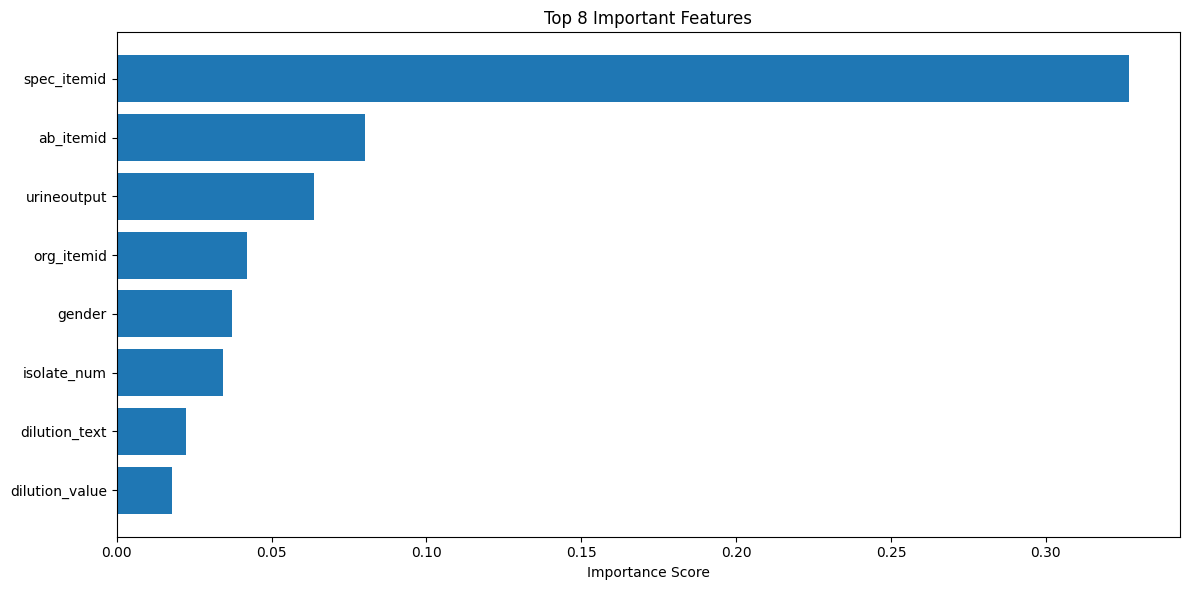


Feature Importance for Model 2:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:41<00:00,  1.05s/it]


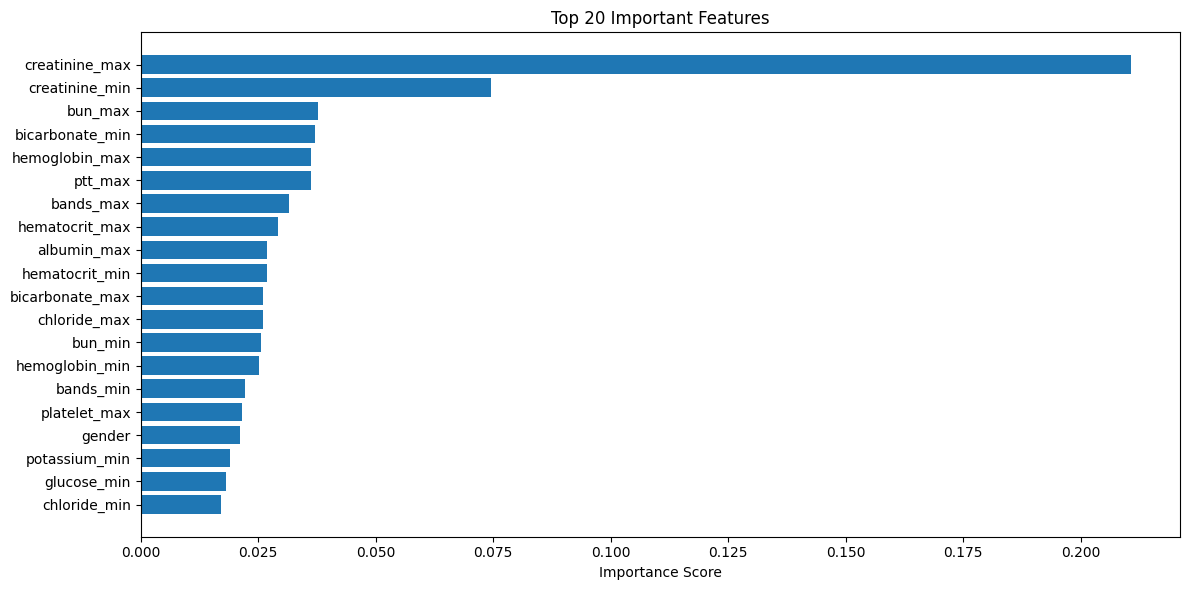


最终验证集类别分布 - 负类: 8474, 正类: 10879

Final Ensemble Performance:
AUC: 0.9601
Accuracy: 0.8980
Precision: 0.9164
Recall: 0.9007
F1: 0.9085


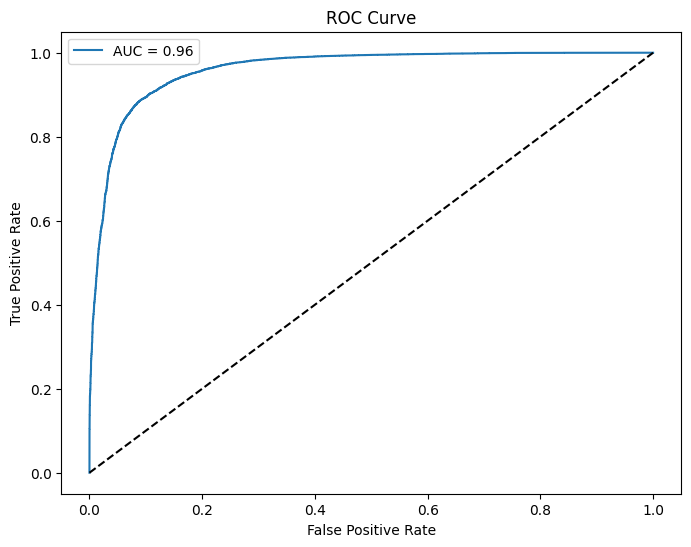

In [7]:
# --------------------------
# 主流程
# --------------------------
# 加载数据
df1 = pd.read_csv('./data/cleaned_microbiologyevents_plus.csv')
df2 = pd.read_csv('./data/cleaned_labs_first_day_lgbm.csv')
target = 'match_flag'

# 数据对齐
common_ids = np.intersect1d(df1['hadm_id'], df2['hadm_id'])  # 假设存在唯一标识列
df1 = df1[df1['hadm_id'].isin(common_ids)].sort_values('hadm_id').reset_index(drop=True)
df2 = df2[df2['hadm_id'].isin(common_ids)].sort_values('hadm_id').reset_index(drop=True)

# 特征工程
feature_names1 = df1.drop(columns=[target, 'hadm_id']).columns.tolist()  # 提取特征名称
feature_names2 = df2.drop(columns=[target, 'hadm_id']).columns.tolist()
X1 = df1.drop(columns=[target, 'hadm_id']).values.astype(np.float32)  # 移除标识列和目标列
X2 = df2.drop(columns=[target, 'hadm_id']).values.astype(np.float32)
y = df1[target].values.astype(np.float32)

# 添加数据完整性检查
print("\n数据完整性验证：")
print(f"X1样本数: {len(X1)}, 特征数: {X1.shape[1]}, 特征名称数: {len(feature_names1)}")
print(f"X2样本数: {len(X2)}, 特征数: {X2.shape[1]}, 特征名称数: {len(feature_names2)}")
print(f"正类比例: {np.mean(y):.2%}")
assert len(X1) == len(X2) == len(y), "特征与标签数量不匹配"
assert X1.shape[1] == len(feature_names1), "X1 特征数量与特征名称不匹配"
assert X2.shape[1] == len(feature_names2), "X2 特征数量与特征名称不匹配"

# 训练模型1
print("\nTraining Model 1...")
dataset1 = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(y))
train_loader1, val_loader1 = create_loaders(dataset1)
model1 = DeepResNet(X1.shape[1]).to(device)
optimizer1 = optim.AdamW(model1.parameters(), lr=0.001, weight_decay=1e-4)
criterion1 = nn.BCEWithLogitsLoss(pos_weight=calc_pos_weight(y))
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='max', factor=0.1, patience=3)
model1, hist1 = train_and_evaluate(model1, train_loader1, val_loader1, optimizer1,
                                 criterion1, scheduler=scheduler1, epochs=40,save_path='best_model1.pth')

# 训练模型2
print("\nTraining Model 2...")
dataset2 = TensorDataset(torch.FloatTensor(X2), torch.FloatTensor(y))
train_loader2, val_loader2 = create_loaders(dataset2)
model2 = DeepResNet(X2.shape[1]).to(device)
optimizer2 = optim.AdamW(model2.parameters(), lr=0.001, weight_decay=1e-4)
criterion2 = nn.BCEWithLogitsLoss(pos_weight=calc_pos_weight(y))
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='max', factor=0.1, patience=3)
model2, hist2 = train_and_evaluate(model2, train_loader2, val_loader2, optimizer2,
                                 criterion2, scheduler=scheduler2, save_path='best_model2.pth')

# 加载最佳模型
model1.load_state_dict(torch.load('best_model1.pth'))
model2.load_state_dict(torch.load('best_model2.pth'))

    # 在模型训练后添加
background_samples = 300  # 控制计算时间

# # 对模型1的分析
# shap_feature_analysis(
#     model1,
#     torch.FloatTensor(X1[:background_samples]),
#     torch.FloatTensor(X1[:5]),  # 解释前100个样本
#     feature_names1,
#     model_name="Microbiology_Model"
# )

# # 对模型2的分析 
# shap_feature_analysis(
#     model2,
#     torch.FloatTensor(X2[:background_samples]),
#     torch.FloatTensor(X2[:10]),
#     feature_names2,
#     model_name="Lab_Model"
# )


# 训练融合模型
print("\nTraining Fusion Model...")
fusion_model = AttentionFusion(model1, model2).to(device)
optimizer = optim.AdamW(fusion_model.parameters(), lr=0.001)
scheduler_fusion = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
dataset = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(X2), torch.FloatTensor(y))
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
epoches = 20
for epoch in range(epoches):
    total_loss = 0
    fusion_model.train()
    for X1_batch, X2_batch, y_batch in train_loader:
        X1_batch, X2_batch = X1_batch.to(device), X2_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        probs = fusion_model(X1_batch, X2_batch)
        loss = nn.BCELoss()(probs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler_fusion.step()
    print(f"Epoch {epoch + 1}: Loss={total_loss / len(train_loader):.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")

# 模型解释与评估
print("\nFeature Importance for Model 1:")
feature_importance(model1, torch.FloatTensor(X1[:1000]).to(device), feature_names1)
print("\nFeature Importance for Model 2:")
feature_importance(model2, torch.FloatTensor(X2[:1000]).to(device), feature_names2)
evaluate_ensemble(fusion_model, X1, X2, y)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

class HierarchicalAttentionFusion(nn.Module):
    """多层次特征融合（修正版）"""

    def __init__(self, modelA, modelB, feat_layers=['stage2', 'stage3']):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.feat_layers = feat_layers

        # 初始化特征存储结构
        self.feats = {'A': {}, 'B': {}}
        
        # 注册前向钩子捕获指定层的输出
        for layer in feat_layers:
            # 确保模型包含目标层
            if not hasattr(modelA, layer):
                raise ValueError(f"ModelA 缺少层 {layer}")
            if not hasattr(modelB, layer):
                raise ValueError(f"ModelB 缺少层 {layer}")
            
            # 注册模型A的钩子
            getattr(modelA, layer).register_forward_hook(
                lambda m, inp, out, l=layer, mid='A': self._save_feat(mid, l, out)
            )
            # 注册模型B的钩子
            getattr(modelB, layer).register_forward_hook(
                lambda m, inp, out, l=layer, mid='B': self._save_feat(mid, l, out)
            )

        # 动态构建投影层和注意力层
        self.projection_dim = 512
        self.projections = nn.ModuleDict({
            layer: nn.Linear(self._get_feature_dim(modelA, layer), self.projection_dim)
            for layer in feat_layers
        })
        self.cross_attentions = nn.ModuleDict({
            layer: nn.MultiheadAttention(embed_dim=self.projection_dim, num_heads=8, batch_first=True)
            for layer in feat_layers
        })

        # 融合门控
        self.gate = nn.Sequential(
            nn.Linear(len(feat_layers)*self.projection_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
            nn.Softmax(dim=1)
        )

    def _get_feature_dim(self, model, layer):
        """获取指定层的输出维度（修正设备问题）"""
        # 获取模型所在设备
        device = next(model.parameters()).device
        # 生成匹配设备的数据
        dummy_input = torch.randn(2, 100).to(device)  # 移动到模型所在设备
        with torch.no_grad():
            _ = model(dummy_input)
            feat = self.feats['A' if model is self.modelA else 'B'][layer]
            return feat.shape[1]

    def _save_feat(self, model_id, layer, output):
        """保存中间特征（修正存储结构）"""
        # 全局平均池化处理 [batch, channels, seq_len] -> [batch, channels]
        pooled = F.adaptive_avg_pool1d(output, 1).squeeze(-1)
        self.feats[model_id][layer] = pooled

    def forward(self, x1, x2):
        # 清空特征缓存
        self.feats = {'A': {}, 'B': {}}
        
        # 前向传播（仅用于捕获特征）
        with torch.no_grad():
            _ = self.modelA(x1)
            _ = self.modelB(x2)

        # 特征融合
        fused_features = []
        for layer in self.feat_layers:
            # 投影特征
            proj_featA = self.projections[layer](self.feats['A'][layer])
            proj_featB = self.projections[layer](self.feats['B'][layer])
            
            # 交叉注意力
            attn_output, _ = self.cross_attentions[layer](
                query=proj_featA.unsqueeze(1),
                key=proj_featB.unsqueeze(1),
                value=proj_featB.unsqueeze(1)
            )
            fused_features.append(attn_output.squeeze(1))
        
        # 门控融合
        gate_input = torch.cat(fused_features, dim=1)
        weights = self.gate(gate_input)
        
        # 获取基础预测
        with torch.no_grad():
            probA = torch.sigmoid(self.modelA(x1))
            probB = torch.sigmoid(self.modelB(x2))
        
        return weights[:, 0] * probA + weights[:, 1] * probB

In [10]:
# --------------------------
# 主流程
# --------------------------
# 加载数据
df1 = pd.read_csv('./data/cleaned_microbiologyevents_plus.csv')
df2 = pd.read_csv('./data/cleaned_labs_first_day_lgbm.csv')
target = 'match_flag'

# 数据对齐
common_ids = np.intersect1d(df1['hadm_id'], df2['hadm_id'])  # 假设存在唯一标识列
df1 = df1[df1['hadm_id'].isin(common_ids)].sort_values('hadm_id').reset_index(drop=True)
df2 = df2[df2['hadm_id'].isin(common_ids)].sort_values('hadm_id').reset_index(drop=True)

# 特征工程
feature_names1 = df1.drop(columns=[target, 'hadm_id']).columns.tolist()  # 提取特征名称
feature_names2 = df2.drop(columns=[target, 'hadm_id']).columns.tolist()
X1 = df1.drop(columns=[target, 'hadm_id']).values.astype(np.float32)  # 移除标识列和目标列
X2 = df2.drop(columns=[target, 'hadm_id']).values.astype(np.float32)
y = df1[target].values.astype(np.float32)

# 添加数据完整性检查
print("\n数据完整性验证：")
print(f"X1样本数: {len(X1)}, 特征数: {X1.shape[1]}, 特征名称数: {len(feature_names1)}")
print(f"X2样本数: {len(X2)}, 特征数: {X2.shape[1]}, 特征名称数: {len(feature_names2)}")
print(f"正类比例: {np.mean(y):.2%}")
assert len(X1) == len(X2) == len(y), "特征与标签数量不匹配"
assert X1.shape[1] == len(feature_names1), "X1 特征数量与特征名称不匹配"
assert X2.shape[1] == len(feature_names2), "X2 特征数量与特征名称不匹配"

# 训练模型1
print("\nTraining Model 1...")
dataset1 = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(y))
train_loader1, val_loader1 = create_loaders(dataset1)
model1 = DeepResNet(X1.shape[1]).to(device)
optimizer1 = optim.AdamW(model1.parameters(), lr=0.001, weight_decay=1e-4)
criterion1 = nn.BCEWithLogitsLoss(pos_weight=calc_pos_weight(y))
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='max', factor=0.1, patience=3)
model1, hist1 = train_and_evaluate(model1, train_loader1, val_loader1, optimizer1,
                                 criterion1, scheduler=scheduler1, epochs=40,save_path='best_model1.pth')

# 训练模型2
print("\nTraining Model 2...")
dataset2 = TensorDataset(torch.FloatTensor(X2), torch.FloatTensor(y))
train_loader2, val_loader2 = create_loaders(dataset2)
model2 = DeepResNet(X2.shape[1]).to(device)
optimizer2 = optim.AdamW(model2.parameters(), lr=0.001, weight_decay=1e-4)
criterion2 = nn.BCEWithLogitsLoss(pos_weight=calc_pos_weight(y))
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='max', factor=0.1, patience=3)
model2, hist2 = train_and_evaluate(model2, train_loader2, val_loader2, optimizer2,
                                 criterion2, scheduler=scheduler2, save_path='best_model2.pth')


数据完整性验证：
X1样本数: 19353, 特征数: 8, 特征名称数: 8
X2样本数: 19353, 特征数: 39, 特征名称数: 39
正类比例: 56.21%

Training Model 1...
Epoch 1/40
Train Loss: 0.4632
Val AUC: 0.8589 | F1: 0.8368 | Accuracy: 0.8189 | Precision: 0.8480
Saved new best model with AUC: 0.8589
Epoch 2/40
Train Loss: 0.4136
Val AUC: 0.8656 | F1: 0.8325 | Accuracy: 0.8140 | Precision: 0.8431
Saved new best model with AUC: 0.8656
Epoch 3/40
Train Loss: 0.3935
Val AUC: 0.8733 | F1: 0.8523 | Accuracy: 0.8357 | Precision: 0.8615
Saved new best model with AUC: 0.8733
Epoch 4/40
Train Loss: 0.3851
Val AUC: 0.8538 | F1: 0.8424 | Accuracy: 0.8223 | Precision: 0.8397
Epoch 5/40
Train Loss: 0.3869
Val AUC: 0.8837 | F1: 0.8512 | Accuracy: 0.8336 | Precision: 0.8559
Saved new best model with AUC: 0.8837
Epoch 6/40
Train Loss: 0.3833
Val AUC: 0.8810 | F1: 0.8464 | Accuracy: 0.8318 | Precision: 0.8696
Epoch 7/40
Train Loss: 0.3747
Val AUC: 0.8746 | F1: 0.8500 | Accuracy: 0.8336 | Precision: 0.8620
Epoch 8/40
Train Loss: 0.4235
Val AUC: 0.8554 | F1: 0.

KeyboardInterrupt: 

In [ ]:
from torch.nn import functional as F
# 加载最佳模型
model1.load_state_dict(torch.load('best_model1.pth'))
model2.load_state_dict(torch.load('best_model2.pth'))

    # 在模型训练后添加
background_samples = 300  # 控制计算时间

# # 对模型1的分析
# shap_feature_analysis(
#     model1,
#     torch.FloatTensor(X1[:background_samples]),
#     torch.FloatTensor(X1[:5]),  # 解释前100个样本
#     feature_names1,
#     model_name="Microbiology_Model"
# )

# # 对模型2的分析 
# shap_feature_analysis(
#     model2,
#     torch.FloatTensor(X2[:background_samples]),
#     torch.FloatTensor(X2[:10]),
#     feature_names2,
#     model_name="Lab_Model"
# )


# 训练融合模型
print("\nTraining HierarchicalAttentionFusion Model...")
fusion_model = fusion_model = HierarchicalAttentionFusion(
    model1, 
    model2,
    feat_layers=['stage2', 'stage3'] , # 根据实际需要选择层 
).to(device)
optimizer = optim.AdamW(fusion_model.parameters(), lr=0.001)
scheduler_fusion = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
dataset = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(X2), torch.FloatTensor(y))
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
epoches = 20
for epoch in range(epoches):
    total_loss = 0
    fusion_model.train()
    for X1_batch, X2_batch, y_batch in train_loader:
        X1_batch, X2_batch = X1_batch.to(device), X2_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        probs = fusion_model(X1_batch, X2_batch)
        loss = nn.BCELoss()(probs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler_fusion.step()
    print(f"Epoch {epoch + 1}: Loss={total_loss / len(train_loader):.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")

# 模型解释与评估
print("\nFeature Importance for Model 1:")
feature_importance(model1, torch.FloatTensor(X1[:1000]).to(device), feature_names1)
print("\nFeature Importance for Model 2:")
feature_importance(model2, torch.FloatTensor(X2[:1000]).to(device), feature_names2)
evaluate_ensemble(fusion_model, X1, X2, y)


# 训练融合模型
print("\nTraining Fusion Model...")
fusion_model = AttentionFusion(model1, model2).to(device)
optimizer = optim.AdamW(fusion_model.parameters(), lr=0.001)
scheduler_fusion = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
dataset = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(X2), torch.FloatTensor(y))
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
epoches = 20
for epoch in range(epoches):
    total_loss = 0
    fusion_model.train()
    for X1_batch, X2_batch, y_batch in train_loader:
        X1_batch, X2_batch = X1_batch.to(device), X2_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        probs = fusion_model(X1_batch, X2_batch)
        loss = nn.BCELoss()(probs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler_fusion.step()
    print(f"Epoch {epoch + 1}: Loss={total_loss / len(train_loader):.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")

# 模型解释与评估
print("\nFeature Importance for Model 1:")
feature_importance(model1, torch.FloatTensor(X1[:1000]).to(device), feature_names1)
print("\nFeature Importance for Model 2:")
feature_importance(model2, torch.FloatTensor(X2[:1000]).to(device), feature_names2)
evaluate_ensemble(fusion_model, X1, X2, y)

In [34]:
print(model1.stage1)

Sequential(
  (0): BottleneckResidualBlock(
    (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
    (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (se): Sequential(
      (0): AdaptiveAvgPool1d(output_size=1)
      (1): Conv1d(256, 16, kernel_size=(1,), stride=(1,))
      (2): ReLU()
      (3): Conv1d(16, 256, kernel_size=(1,), stride=(1,))
      (4): Sigmoid()
    